Running WaveStats Algorithm:
Starting initializations


Algorithm Successful.
Using a threshold of 6.500000:
The total number of waves measured this session was: 151.
The total time for this session was: 3434.833000 secs (or 57.247217 mins).
Calculated Average Wave Height as: 1.132537 m.
Calculated Significant Wave Height as: 3.284337 m.
Calculated Average Wave Period as: 6.281404 s.
Calculated Average Wave Frequency as: 0.159200 Hz.


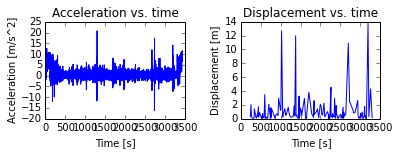

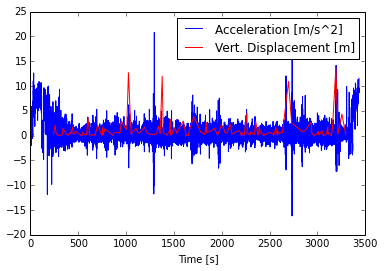

In [123]:
#Purisa Jasmine Simmons
#WaveStats2.0
#Going to focus on y-axis AMU readings (AMU2) with a filter to detect when
#board is in relatively correct position, which is around 512 raw units. 

%matplotlib inline

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from plotly import tools
import plotly.offline
import plotly.graph_objs as go

import math
import re

#Need to do peak-picking before algorithm runs:
#1. Read through file, save all times and accelerations:
print('Running WaveStats Algorithm:')

#Reading data from filename_r
filename_r = "Motion_13735.CSV"
read_file = open(filename_r, "r")

#Initialize lists
t1 = 0 
t2 = 0
time_o_list = []  #list of time offsets; t_out = current_time - prev_time 
time_e_list = []
imu1_list = []
imu2_list = []   #list of estimated accelerations
imu3_list = []
acc_list = []

disp_list = []     #list of calculated vertical displacements
disp_t_list = []   #list of time_elapsed for each vertical displacement

with open(filename_r, 'r') as f: 
  for line in f:
    #print line     #helps with debugging
    str_array = line.split(',')  #separates each line into an array on commas

    #-------Calculating Time Offset--------#
    if str_array[1] == "Time":
      t1 = 0
      t2 = 0
      time_o_list.append(0)  #initialize time_list with 0
      time_e_list.append(0)

    else:
      t2 = str_array[1]    #Using "Time" Column instead of "UTC" column

      if (t2 != 0 and t1 != 0 and str_array[2] != "N/A"):
        t_out = float(t2) - float(t1) #measured in secs
        t_out = (t_out*(10**-3))

        last_ti = len(time_o_list) - 1 #index of last time_offset
        last_te = time_e_list[last_ti] #last time_elapsed
        time_e_list.append(last_te + t_out)  #last time_elapsed + time_offset
        time_o_list.append(t_out)
      
        #print(("Time offset is: %f") % (t_out))

        
      if (str_array[2] != "N/A" and str_array[3] != "N/A" and \
        str_array[4] != "N/A" and str_array[2] != "IMU A1"):


        #Scale raw to get correct units in m/s^2
        g_const = 512            #g is the constant for gravity: 500 (measured in g?)
        gravity = -9.80665

        ax = float(str_array[2])  #x-axis (horizontal direction 1)
        ay = float(str_array[3])  #y-axis, affected by gravity (vertical)
        az = float(str_array[4])  #z-axis (horizontal direction 2)

        #print(("ax: %f") % ax) 
        #print(("ay: %f") % ay)
        #print(("az: %f") % az)
        
        imu1_list.append(ax)
        imu2_list.append(ay)
        imu3_list.append(az)
        
        acc = float(float(float(ay/g_const)*gravity)-gravity)
        acc_list.append(acc)
        
        #print('Vertical acceleration is: %f' % ay)


    #Reset t1 and t2 after t_out is calculated
    t1 = t2
    t2 = 0

#----------Here, after both lists created----------
#Now, calculate wave heights between peaks and valleys.


if len(time_o_list) != len(imu2_list):
    print("Error! Lengths of time_list and vert_list don't match!")
    print("Length of time_list: %d" % time_list)
    print("Length of imu2_list: %d" % imu2_list)
    
else:
    #Initializations
    print("Starting initializations")
    a0 = 0
    v0 = 0
    d0 = 0
    
    i = 2
    minNotFound = 1
    numWaves = 0       #total number of waves
    waveHeight = 0     #est. individual wave height
    waveFreq = 0       #est. individual wave frequency
    wave_pi = 0         #est. individual wave period
    
    total_WH = 0       #total wave heights for ride
    total_WF = 0       #total wave freqs for ride
    total_WP = 0       #total wave periods for ride
    
    max_wi = 0
    min_wi = 0

    #---------Update the threshold---------
    threshold = 6.5
    
    v_min = 300
    v_max = 700
    
    end = len(imu2_list)
    
    while(i < (end - 3)):
        #print ("First while loop")
        a_prev2 = float(imu2_list[i-2])
        a_prev1 = float(imu2_list[i-1])
        a_this = float(imu2_list[i])
        a_next1 = float(imu2_list[i+1])
        a_next2 = float(imu2_list[i+2])
        
        #Peak-picking and vertical axis (imu2) check:
        if (a_this > a_prev1 + threshold and a_next1 > a_this + threshold \
            and a_prev1 > a_prev2 + threshold and a_next2 > a_next1 + threshold \
            and a_this > v_min and a_this < v_max):
            
            max_wi = i
            
            #Do calculations until a new min is found 
            while (minNotFound and i < (end - 3) and imu2_list[i] > v_min \
                   and imu2_list[i] < v_max):
                #print ("While min not found loop")
                t = time_o_list[i]
                a_new = float(float(float(imu2_list[i]/g_const)*gravity)-gravity)
                v_new = (a_new*t) + v0
                d_new = (0.5*a_new*(t**2)) + v_new*t + d0 
    
                wave_pi = time_o_list[i+1] + wave_pi 
            
                #Check for next min point
                if (a_this < a_prev1 - threshold and a_this < a_next1 - threshold \
                    and a_prev1 < a_prev2 - threshold and a_next1 < a_next2 - threshold \
                    and a_this > v_min and a_this < v_max):
                
                    minNotFound = 0
                    min_wi = i
                
                    t = time_o_list[i]
                    a_new = float(float(float(imu2_list[i]/g_const)*gravity)-gravity)
                    
                    #print("a_new is: %f"%a_new)
                    v_new = float((a_new*t) + v0)
                    d_new = float((0.5*a_new*(t**2)) + v_new*t + d0) 
                    wave_pi = float(time_o_list[i] + wave_pi)
                
                    #Don't count heights greater than 20m, unreasonable.
                    if (abs(d_new) < 20):
                        numWaves = numWaves + 1
                        waveHeight = abs(d_new)
                        total_WH = total_WH + waveHeight
                        disp_list.append(waveHeight)
                        te = time_e_list[i]
                        disp_t_list.append(te)
                    
                        if (wave_pi > 0):
                            wave_pi = float(2*wave_pi)
                            total_WP = float(total_WP + wave_pi)
                            #print("The wave height is: %f and the period is: %f at time_e: %f" \
                            #     %(waveHeight, wave_pi, te))
                        
                        
                #Set all parameters for next sample wave
                a0 = a_new
                v0 = v_new
                d0 = d_new
                
                i = i + 1
                a_prev2 = float(imu2_list[i-2])
                a_prev1 = float(imu2_list[i-1])
                a_this = float(imu2_list[i])
                a_next1 = float(imu2_list[i+1])
                a_next2 = float(imu2_list[i+2])
                
        #Reset after every max point found
        a0 = 0
        v0 = 0
        d0 = 0
            
        minNotFound = 1
        waveHeight = 0
        waveFreq = 0
            
        max_wi = 0
        min_wi = 0
        wave_pi = 0
        
        #print("Incrementing i")    
        i = i + 1
            
            
#At the end of the .CSV file, return the results:
if numWaves == 0:
    print("Error! No waves detected, (numWaves = 0).")
else:
    avg_WH_m = total_WH/numWaves
    avg_WP = total_WP/numWaves
    #avg_WF = total_WF/numWaves
                    
    last_time_e = len(time_e_list) - 1
    total_time_secs = time_e_list[last_time_e]
    total_time_mins= total_time_secs/60 
    
    #Sort the displacements, get the significant wave heights
    sig_list = disp_list[:]
    big_third = len(sig_list)/3
    sig_list.sort()
    sig_list = sig_list[big_third:]
    sum_sig = math.fsum(sig_list)
    sig_WH = sum_sig/big_third
    
    
    print("\n") 
    print("Algorithm Successful.")
    print("Using a threshold of %f:" % threshold)
    print("The total number of waves measured this session was: %d." % numWaves)
    print("The total time for this session was: %f secs (or %f mins)." \
        %(total_time_secs, total_time_mins))
    print("Calculated Average Wave Height as: %f m." % avg_WH_m) 
    print("Calculated Significant Wave Height as: %f m." % sig_WH)
    print("Calculated Average Wave Period as: %f s." % avg_WP) 
    if (avg_WP != 0):
      print("Calculated Average Wave Frequency as: %f Hz." % (1/avg_WP))
    #print "Calculated Average Wave Frequency as: %f Hz." % avg_WF
    
    
    #--------Here, after calculations, ready to graph---------

    disp_time_array = np.array(disp_t_list)
    disp_array = np.array(disp_list)
    
    time_array = np.array(time_e_list)
    acc_array = np.array(acc_list)   #acc_list gets vertical acceleration from y-axis imu2
    
    grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
    
    plt.subplot(grid[0, 0])
    plt.plot(time_array, acc_array)
    plt.title('Acceleration vs. time')
    plt.ylabel('Acceleration [m/s^2]')
    plt.xlabel('Time [s]')
    
    plt.subplot(grid[0, 1:])
    plt.plot(disp_time_array, disp_array)
    plt.title("Displacement vs. time")
    plt.ylabel("Displacement [m]")
    plt.xlabel("Time [s]")
    
    
    #plt.subplot(grid[1, 0])
    fig, ax = plt.subplots()
    ax.set_color_cycle(['blue', 'red'])
    plt.plot(time_array, acc_array, label="Acceleration [m/s^2]")
    plt.plot(disp_time_array, disp_array, label="Vert. Displacement [m]")
    plt.legend(loc="best")
    plt.xlabel('Time [s]')
    #plt.legend('Acceleration', 'Displacement', loc='upper left')

    #plt.subplots_adjust(left=0.1, bottom=0.1, right=1.0, top=0.9,
    #            wspace=0.2, hspace=0.1)

    
    #plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    #plt.tight_layout()
    
 
    
    plt.show()




Running WaveStats Algorithm:
Starting initializations


Algorithm Successful.
Using a threshold of 6.500000:
The total number of waves measured this session was: 151.
The total time for this session was: 3434.833000 secs (or 57.247217 mins).
Calculated Average Wave Height as: 1.132537 m.
Calculated Significant Wave Height as: 3.284337 m.
Calculated Average Wave Period as: 6.281404 s.
Calculated Average Wave Frequency as: 0.159200 Hz.


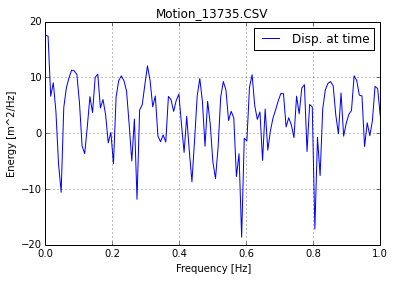

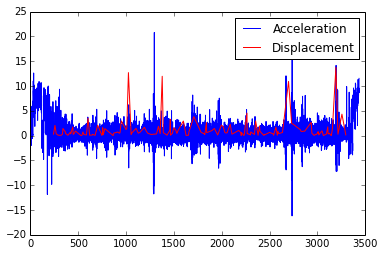

In [133]:
#Purisa Jasmine Simmons
#WaveStats2.0
#Going to focus on y-axis AMU readings (AMU2) with a filter to detect when
#board is in relatively correct position, which is around 512 raw units. 

%matplotlib inline

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from plotly import tools
import plotly.offline
import plotly.graph_objs as go

import math
import re

#Need to do peak-picking before algorithm runs:
#1. Read through file, save all times and accelerations:
print('Running WaveStats Algorithm:')

#Reading data from filename_r
filename_r = "Motion_13735.CSV"
read_file = open(filename_r, "r")

#Initialize lists
t1 = 0 
t2 = 0
time_o_list = []  #list of time offsets; t_out = current_time - prev_time 
time_e_list = []
imu1_list = []
imu2_list = []   #list of estimated accelerations
imu3_list = []
acc_list = []

disp_list = []     #list of calculated vertical displacements
disp_t_list = []   #list of time_elapsed for each vertical displacement

with open(filename_r, 'r') as f: 
  for line in f:
    #print line     #helps with debugging
    str_array = line.split(',')  #separates each line into an array on commas

    #-------Calculating Time Offset--------#
    if str_array[1] == "Time":
      t1 = 0
      t2 = 0
      time_o_list.append(0)  #initialize time_list with 0
      time_e_list.append(0)

    else:
      t2 = str_array[1]    #Using "Time" Column instead of "UTC" column

      if (t2 != 0 and t1 != 0 and str_array[2] != "N/A"):
        t_out = float(t2) - float(t1) #measured in secs
        t_out = (t_out*(10**-3))

        last_ti = len(time_o_list) - 1 #index of last time_offset
        last_te = time_e_list[last_ti] #last time_elapsed
        time_e_list.append(last_te + t_out)  #last time_elapsed + time_offset
        time_o_list.append(t_out)
      
        #print(("Time offset is: %f") % (t_out))

        
      if (str_array[2] != "N/A" and str_array[3] != "N/A" and \
        str_array[4] != "N/A" and str_array[2] != "IMU A1"):


        #Scale raw to get correct units in m/s^2
        g_const = 512            #g is the constant for gravity: 500 (measured in g?)
        gravity = -9.80665

        ax = float(str_array[2])  #x-axis (horizontal direction 1)
        ay = float(str_array[3])  #y-axis, affected by gravity (vertical)
        az = float(str_array[4])  #z-axis (horizontal direction 2)

        #print(("ax: %f") % ax) 
        #print(("ay: %f") % ay)
        #print(("az: %f") % az)
        
        imu1_list.append(ax)
        imu2_list.append(ay)
        imu3_list.append(az)
        
        acc = float(float(float(ay/g_const)*gravity)-gravity)
        acc_list.append(acc)
        
        #print('Vertical acceleration is: %f' % ay)


    #Reset t1 and t2 after t_out is calculated
    t1 = t2
    t2 = 0

#----------Here, after both lists created----------
#Now, calculate wave heights between peaks and valleys.


if len(time_o_list) != len(imu2_list):
    print("Error! Lengths of time_list and vert_list don't match!")
    print("Length of time_list: %d" % time_list)
    print("Length of imu2_list: %d" % imu2_list)
    
else:
    #Initializations
    print("Starting initializations")
    a0 = 0
    v0 = 0
    d0 = 0
    
    i = 2
    minNotFound = 1
    numWaves = 0       #total number of waves
    waveHeight = 0     #est. individual wave height
    waveFreq = 0       #est. individual wave frequency
    wave_pi = 0         #est. individual wave period
    
    total_WH = 0       #total wave heights for ride
    total_WF = 0       #total wave freqs for ride
    total_WP = 0       #total wave periods for ride
    
    max_wi = 0
    min_wi = 0

    #---------Update the threshold---------
    threshold = 6.5
    
    v_min = 300
    v_max = 700
    
    end = len(imu2_list)
    
    while(i < (end - 3)):
        #print ("First while loop")
        a_prev2 = float(imu2_list[i-2])
        a_prev1 = float(imu2_list[i-1])
        a_this = float(imu2_list[i])
        a_next1 = float(imu2_list[i+1])
        a_next2 = float(imu2_list[i+2])
        
        #Peak-picking and vertical axis (imu2) check:
        if (a_this > a_prev1 + threshold and a_next1 > a_this + threshold \
            and a_prev1 > a_prev2 + threshold and a_next2 > a_next1 + threshold \
            and a_this > v_min and a_this < v_max):
            
            max_wi = i
            
            #Do calculations until a new min is found 
            while (minNotFound and i < (end - 3) and imu2_list[i] > v_min \
                   and imu2_list[i] < v_max):
                #print ("While min not found loop")
                t = time_o_list[i]
                a_new = float(float(float(imu2_list[i]/g_const)*gravity)-gravity)
                v_new = (a_new*t) + v0
                d_new = (0.5*a_new*(t**2)) + v_new*t + d0 
    
                wave_pi = time_o_list[i+1] + wave_pi 
            
                #Check for next min point
                if (a_this < a_prev1 - threshold and a_this < a_next1 - threshold \
                    and a_prev1 < a_prev2 - threshold and a_next1 < a_next2 - threshold \
                    and a_this > v_min and a_this < v_max):
                
                    minNotFound = 0
                    min_wi = i
                
                    t = time_o_list[i]
                    a_new = float(float(float(imu2_list[i]/g_const)*gravity)-gravity)
                    
                    #print("a_new is: %f"%a_new)
                    v_new = float((a_new*t) + v0)
                    d_new = float((0.5*a_new*(t**2)) + v_new*t + d0) 
                    wave_pi = float(time_o_list[i] + wave_pi)
                
                    #Don't count heights greater than 20m, unreasonable.
                    if (abs(d_new) < 20):
                        numWaves = numWaves + 1
                        waveHeight = abs(d_new)
                        total_WH = total_WH + waveHeight
                        disp_list.append(waveHeight)
                        te = time_e_list[i]
                        disp_t_list.append(te)
                    
                        if (wave_pi > 0):
                            wave_pi = float(2*wave_pi)
                            total_WP = float(total_WP + wave_pi)
                            #print("The wave height is: %f and the period is: %f at time_e: %f" \
                            #     %(waveHeight, wave_pi, te))
                        
                        
                #Set all parameters for next sample wave
                a0 = a_new
                v0 = v_new
                d0 = d_new
                
                i = i + 1
                a_prev2 = float(imu2_list[i-2])
                a_prev1 = float(imu2_list[i-1])
                a_this = float(imu2_list[i])
                a_next1 = float(imu2_list[i+1])
                a_next2 = float(imu2_list[i+2])
                
        #Reset after every max point found
        a0 = 0
        v0 = 0
        d0 = 0
            
        minNotFound = 1
        waveHeight = 0
        waveFreq = 0
            
        max_wi = 0
        min_wi = 0
        wave_pi = 0
        
        #print("Incrementing i")    
        i = i + 1
            
            
#At the end of the .CSV file, return the results:
if numWaves == 0:
    print("Error! No waves detected, (numWaves = 0).")
else:
    avg_WH_m = total_WH/numWaves
    avg_WP = total_WP/numWaves
    #avg_WF = total_WF/numWaves
                    
    last_time_e = len(time_e_list) - 1
    total_time_secs = time_e_list[last_time_e]
    total_time_mins= total_time_secs/60 
    
    #Sort the displacements, get the significant wave heights
    sig_list = disp_list[:]
    big_third = len(sig_list)/3
    sig_list.sort()
    sig_list = sig_list[big_third:]
    #sum_sig = sum(sig_list)
    sig_WH = math.fsum(sig_list)/big_third
    
    
    print("\n") 
    print("Algorithm Successful.")
    print("Using a threshold of %f:" % threshold)
    print("The total number of waves measured this session was: %d." % numWaves)
    print("The total time for this session was: %f secs (or %f mins)." \
        %(total_time_secs, total_time_mins))
    print("Calculated Average Wave Height as: %f m." % avg_WH_m) 
    print("Calculated Significant Wave Height as: %f m." % sig_WH)
    print("Calculated Average Wave Period as: %f s." % avg_WP) 
    if (avg_WP != 0):
      print("Calculated Average Wave Frequency as: %f Hz." % (1/avg_WP))
    #print "Calculated Average Wave Frequency as: %f Hz." % avg_WF
    
    
    #--------Here, after calculations, ready to graph---------

    disp_time_array = np.array(disp_t_list)
    disp_array = np.array(disp_list)
    
    time_array = np.array(time_e_list)
    acc_array = np.array(acc_list)
    
    x=disp_array
    f, Pxx_den = signal.periodogram(x, 100)
    #plt.semilogy(f, Pxx_den)
    #plt.xlabel('Frequency [Hz]')
    #plt.ylabel('Energy [m^2Hz]')
    #plt.show()

    ##---------Version 2, wrong axes titles, scaling off by 15------best

    psd_disp = []
    for d in disp_array:
        if (len(psd_disp) == 0):
            psd_disp.append(d)
        else:
            last = len(psd_disp) - 1
            sum_d = psd_disp[last] + d
            psd_disp.append(sum_d)
            
    #dt = 0.01
    #plt.psd(x=psd_disp, Fs=2, label="Disp. over time")
    plt.psd(x=disp_array, Fs=2, label="Disp. at time")
    plt.title(filename_r)
    plt.legend(loc="best")
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy [m^2/Hz]')
    
    
    fig, ax = plt.subplots()
    ax.set_color_cycle(['blue', 'red'])
    plt.plot(time_array, acc_array, label="Acceleration")
    plt.plot(disp_time_array, disp_array, label="Displacement")
    plt.legend(loc="best")
    ##plt.legend('Acceleration', 'Displacement', loc='upper left')

    #plt.subplots_adjust(left=0.1, bottom=0.1, right=1.0, top=0.9,
                #wspace=2.0, hspace=2.0)

    
    #plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    #plt.tight_layout()
    
    plt.show()
    
    